# Store Sales - Time Series Forecasting

The goal of this project is to analyze store sales data and build a time series forecasting model to predict the sales on a daily basis in order to help business to make strategy decision

Data: (link: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview)

## File Descriptions and Data Field Information (from kaggle)

### train.csv
- The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
- store_nbr identifies the store at which the products are sold.
- family identifies the type of product sold.
- sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
- onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

### test.csv
- The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
- The dates in the test data are for the 15 days after the last date in the training data.

### stores.csv
- Store metadata, including city, state, type, and cluster.
- cluster is a grouping of similar stores.

### oil.csv
- Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

### holidays_events.csv
- Holidays and Events, with metadata
- NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
- Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

### Additional Notes
- Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
- A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

## 1. Data Preprocessing

### 1.1 Load Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout
%matplotlib inline

2023-05-02 17:16:53.835726: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train = pd.read_csv('./store-sales-time-series-forecasting/train.csv')
test = pd.read_csv('./store-sales-time-series-forecasting/test.csv')
transactions = pd.read_csv('./store-sales-time-series-forecasting/transactions.csv')
stores = pd.read_csv('./store-sales-time-series-forecasting/stores.csv')
oil = pd.read_csv('./store-sales-time-series-forecasting/oil.csv')
holidays_events = pd.read_csv('./store-sales-time-series-forecasting/holidays_events.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [5]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [6]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [7]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [8]:
holidays_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


### 1.2 Check Duplicates

In [9]:
data_pair = list(zip([train,test,transactions,stores,oil,holidays_events],
                ['train','test','transactions','stores','oil','holidays_events']))
for i in data_pair:
    if i[0].duplicated().sum() > 0:
        print('{:<15}: Has Duplicates'.format(str(i[1])))
    else:
        print('{:<15}: No Duplicates'.format(str(i[1])))

train          : No Duplicates
test           : No Duplicates
transactions   : No Duplicates
stores         : No Duplicates
oil            : No Duplicates
holidays_events: No Duplicates


### 1.3 Check Missing Value

In [10]:
for j in data_pair:
    if j[0].isnull().any().any():
        print('{:<15}: Has Null'.format(str(j[1])))
    else:
        print('{:<15}: No Null'.format(str(j[1])))

train          : No Null
test           : No Null
transactions   : No Null
stores         : No Null
oil            : Has Null
holidays_events: No Null


### 1.4 Handle Missing Value

In [11]:
oil.isnull().mean() * 100

date          0.000000
dcoilwtico    3.530378
dtype: float64

In [12]:
# Since only 3.5% of data is missing, we can fill missing value with median.
oil['dcoilwtico'] = oil['dcoilwtico'].fillna(oil['dcoilwtico'].median())

### 1.5 Combine Data

In [13]:
# Combine train and test
all_data = pd.concat([train,test])
# Join train and test with transactions on date,store_nbr
new_all = pd.merge(all_data, transactions, on=['date','store_nbr'], how='left')
# Join with stores on store_nbr
new_all = pd.merge(new_all, stores, on=['store_nbr'], how='left')
# Join with oil on date
new_all = pd.merge(new_all, oil, on=['date'], how='left')

In [14]:
new_all['date'] = pd.to_datetime(new_all['date'])
new_all['transactions'] = new_all['transactions'].fillna(0)
new_all['dcoilwtico'].fillna(method='ffill', inplace=True)

## 2. Data Visualization

### 2.1 Sales vs Oil Price

In [15]:
new_all["year_month"] = new_all["date"].dt.strftime("%Y-%m")
sales_oil_df = new_all[new_all['date']<'2017-08-01'].\
                        groupby(['year_month']).agg({"dcoilwtico": "mean", "sales": "sum"}).reset_index()

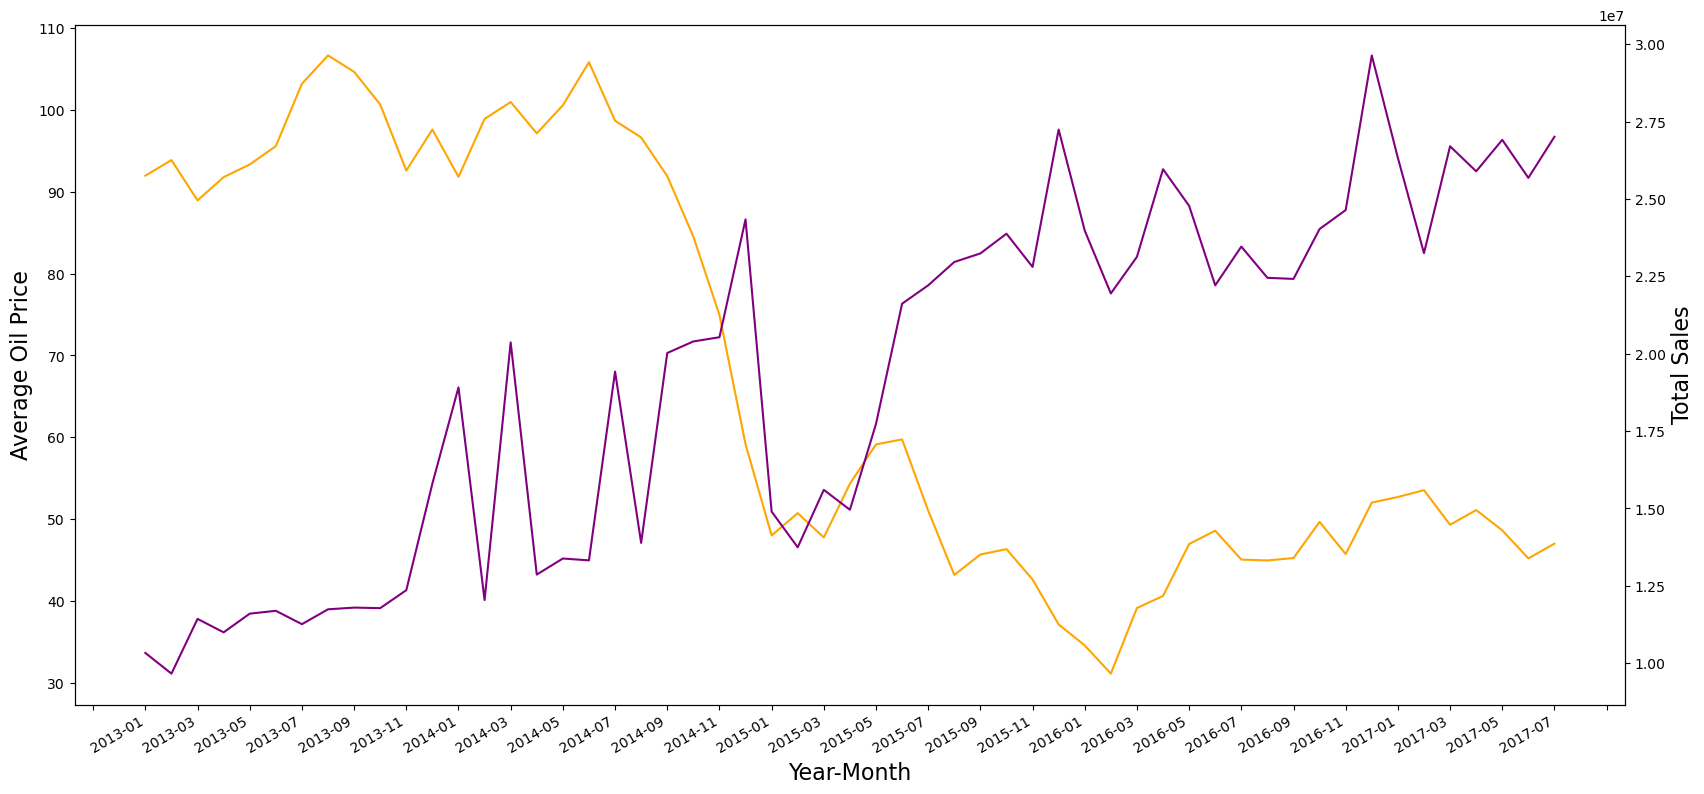

In [16]:
# Purple is total sales, orange is average oil price
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()

sns.lineplot(x="year_month", y="dcoilwtico", data=sales_oil_df, ax=ax1,color='orange')
sns.lineplot(x="year_month", y="sales", data=sales_oil_df, ax=ax2,color='purple')

ax1.set_xlabel("Year-Month",fontsize=16)
ax1.set_ylabel("Average Oil Price",fontsize=16)
ax2.set_ylabel("Total Sales",fontsize=16)

fig.subplots_adjust(bottom=0.2)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(32))
plt.gcf().autofmt_xdate()
plt.show()

As we can see from the plot, sales are going up and oil price are going down from time to time. Some major event happened around early 2015 where both oil price and sales drop significantly

### 2.2 Sales By City

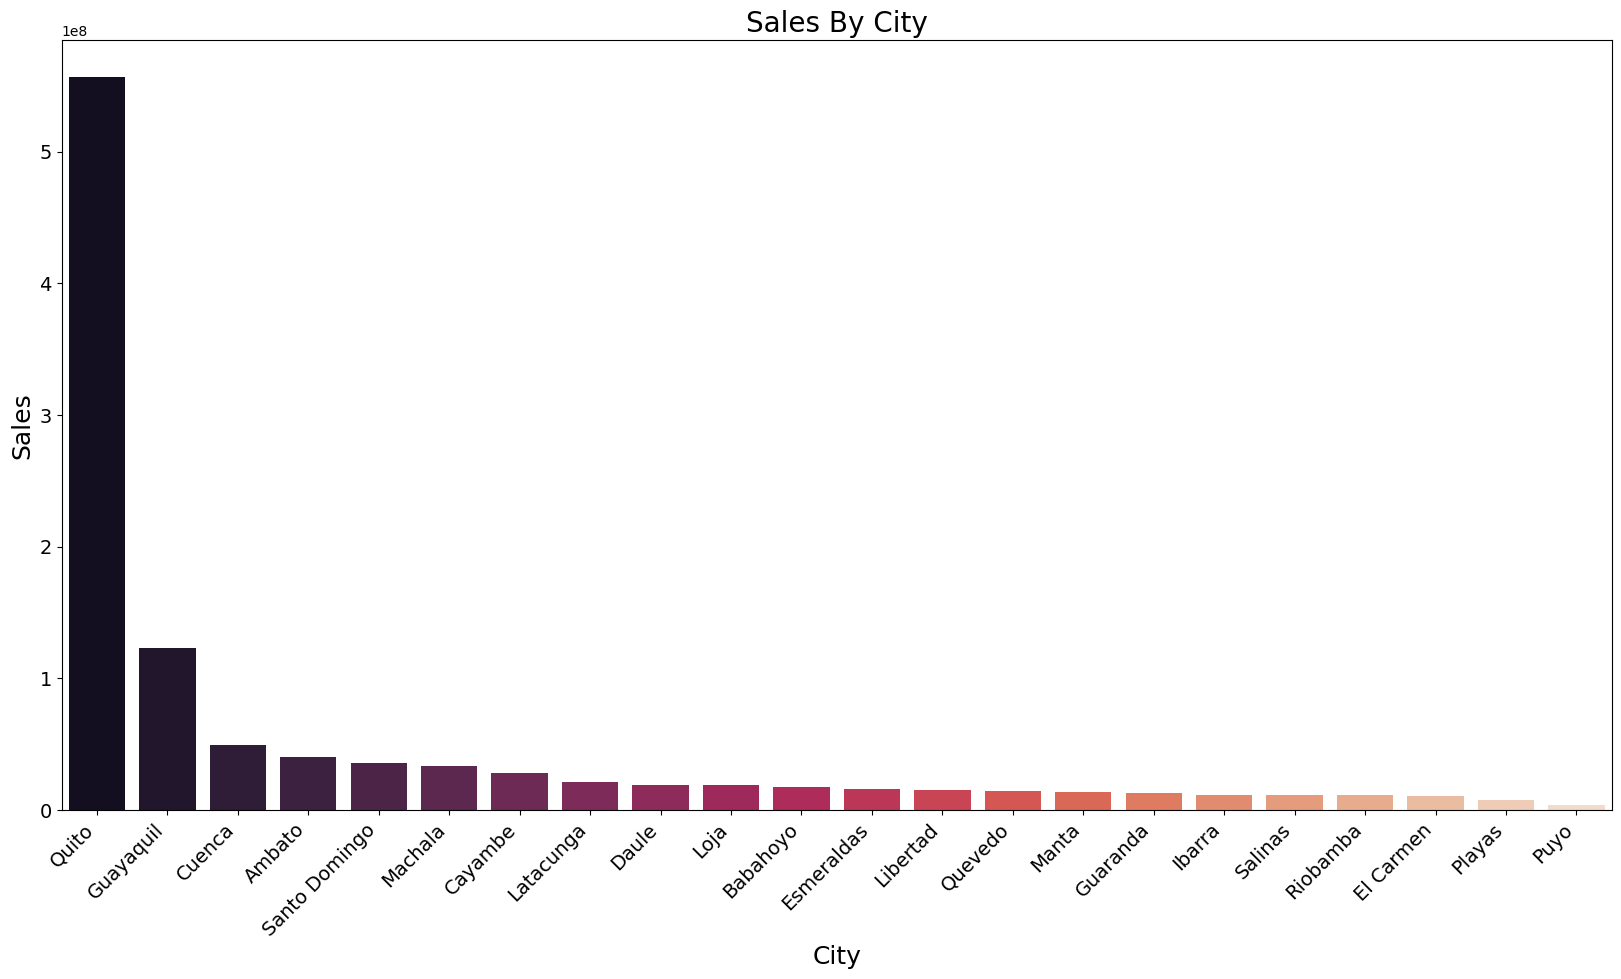

In [17]:
sales_by_city = new_all.groupby(['city']).agg({"sales": "sum"}).sort_values(by='sales', ascending=False)

plt.subplots(figsize=(20, 10))
sns.barplot(x=sales_by_city.index, y=sales_by_city['sales'], palette='rocket')
plt.xticks(rotation=45, ha='right',fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('City',fontsize=18)
plt.ylabel('Sales',fontsize=18)
plt.title('Sales By City',fontsize=20)
plt.show()

As we can see from the plot, Quito has most sales over time which is more than rest city combined

### 2.3 Sales By State

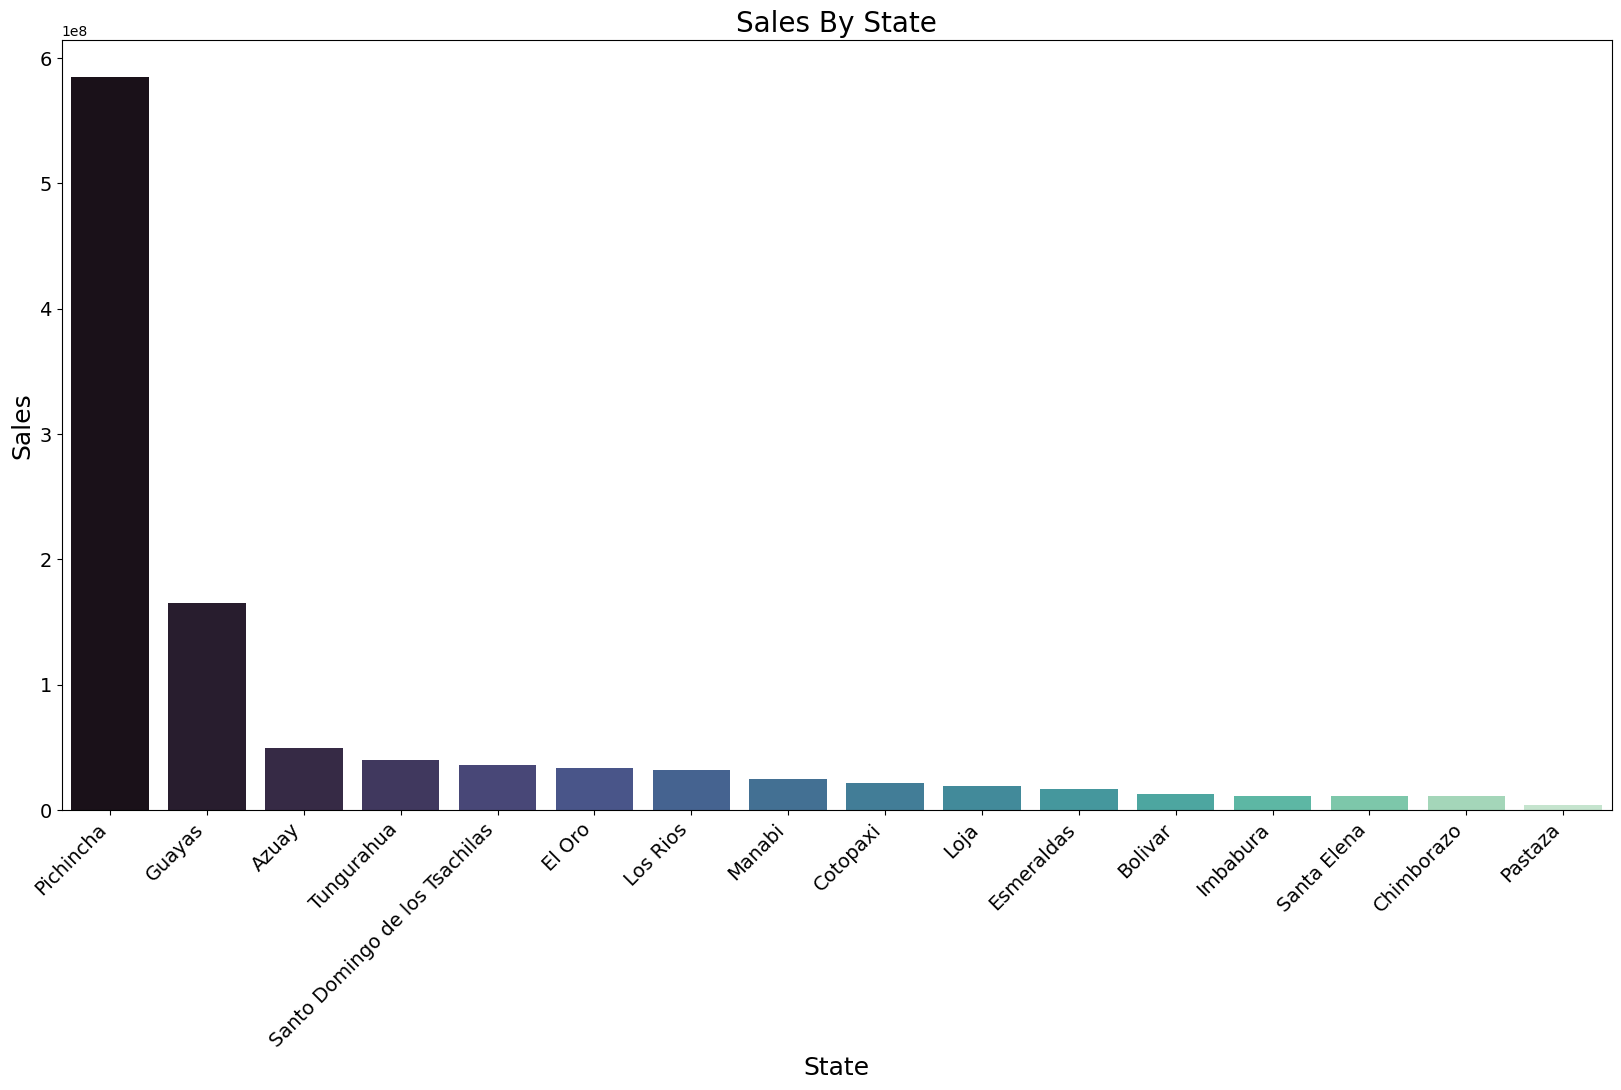

In [18]:
sales_by_state = new_all.groupby(['state']).agg({"sales": "sum"}).sort_values(by='sales', ascending=False)

plt.subplots(figsize=(20, 10))
sns.barplot(x=sales_by_state.index, y=sales_by_state['sales'], palette='mako')
plt.xticks(rotation=45, ha='right',fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('State',fontsize=18)
plt.ylabel('Sales',fontsize=18)
plt.title('Sales By State',fontsize=20)
plt.show()

As we can see from the plot, Pichincha has most sales over time which is more than rest state combined

### 2.4 Sales By Family (Product Type)

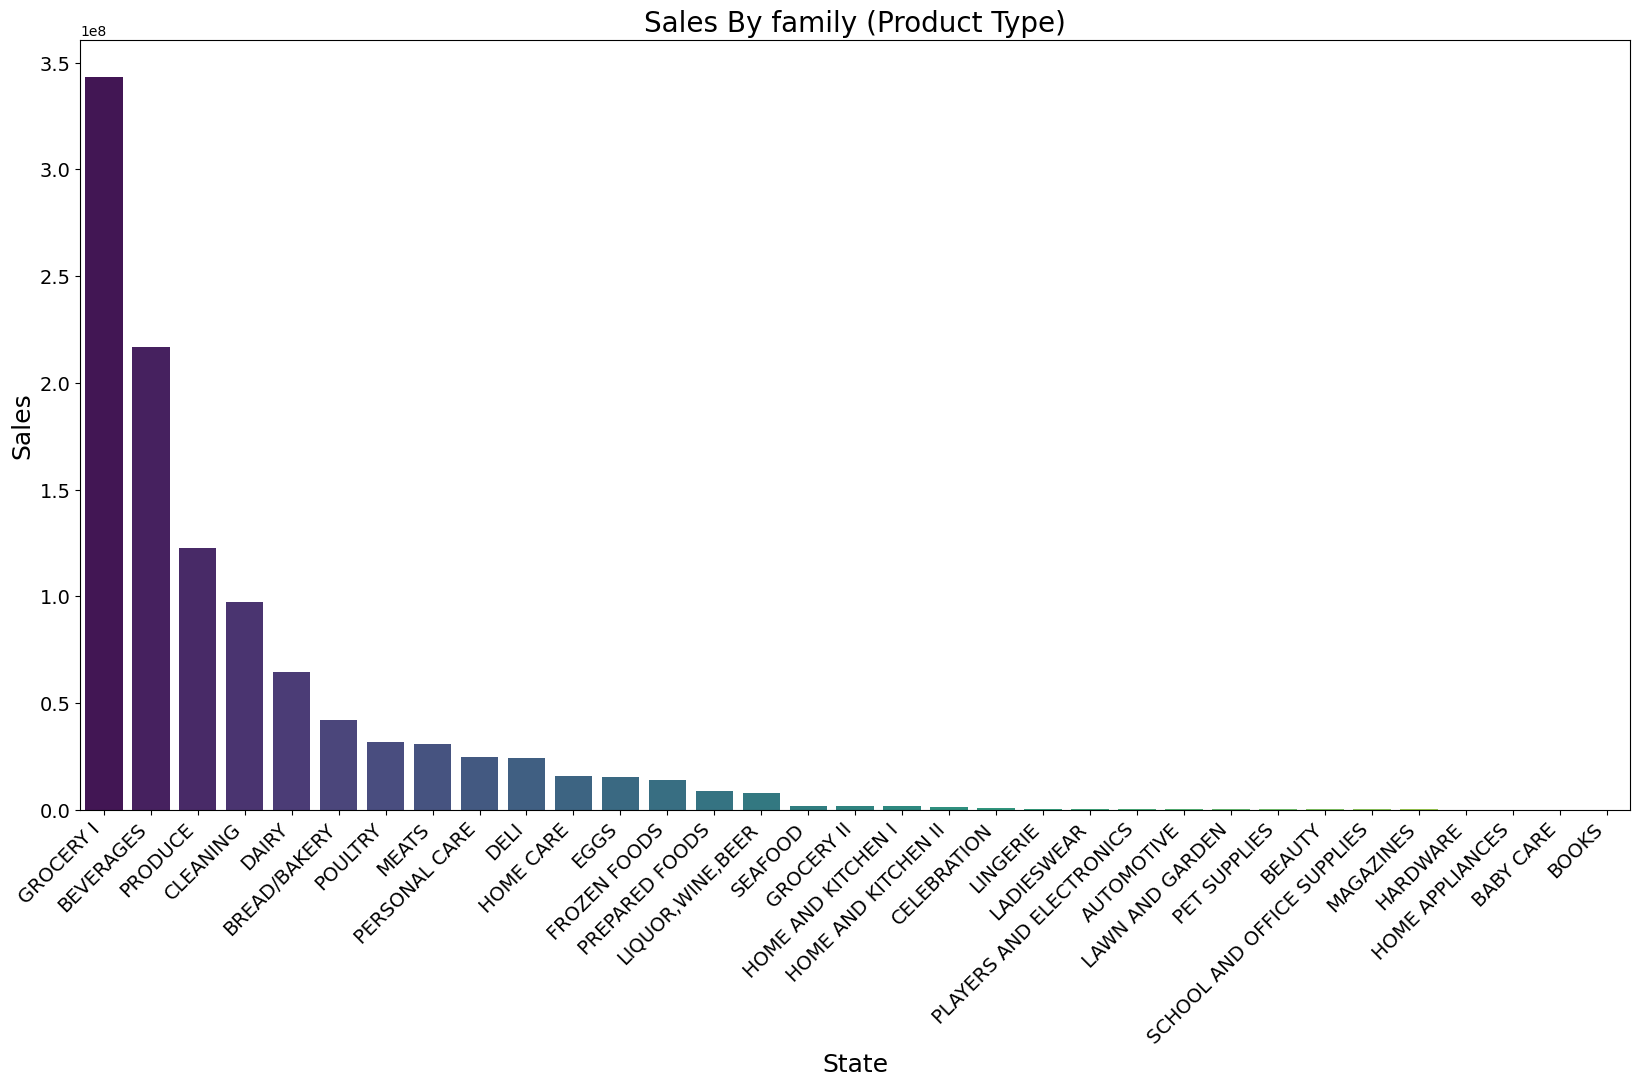

In [19]:
sales_by_family = new_all.groupby(['family']).agg({"sales": "sum"}).sort_values(by='sales', ascending=False)

plt.subplots(figsize=(20, 10))
sns.barplot(x=sales_by_family.index, y=sales_by_family['sales'], palette='viridis')
plt.xticks(rotation=45, ha='right',fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('State',fontsize=18)
plt.ylabel('Sales',fontsize=18)
plt.title('Sales By family (Product Type)',fontsize=20)
plt.show()

As we can see from the plot, the top 3 sales of product type are grocery,beverages and product

## 3. Feature Engineering

### 3.1 Add Date Indicator Column

In [20]:
new_all['day'] = new_all['date'].dt.day
new_all['month'] = new_all['date'].dt.month
new_all['year'] = new_all['date'].dt.year
new_all['day_of_week'] = new_all['date'].dt.dayofweek

### 3.2 Add Holiday Data

In [21]:
holidays_events['date'] = pd.to_datetime(holidays_events['date'])
holidays_events = holidays_events.rename(columns={'type':'h_type'})
h1 = holidays_events[(holidays_events['locale']=='Local')&(holidays_events['h_type']=='Holiday')].\
        drop(columns=['locale','description','transferred']).drop_duplicates()
h2 = holidays_events[(holidays_events['locale']=='Regional')&(holidays_events['h_type']=='Holiday')].\
        drop(columns=['locale','description','transferred']).drop_duplicates()
h3 = holidays_events[(holidays_events['locale']=='National')&(holidays_events['h_type']=='Holiday')].\
        drop(columns=['locale','description','transferred']).drop_duplicates()

In [22]:
new_all = pd.merge(new_all,h1,left_on=['city','date'], right_on=['locale_name', 'date'],how='left').\
                                drop(columns=['locale_name'])
new_all = new_all.rename(columns={'h_type':'Local_Holiday'})
new_all = pd.merge(new_all,h2,left_on=['state', 'date'], right_on=['locale_name', 'date'],how='left').\
                                drop(columns=['locale_name'])
new_all = new_all.rename(columns={'h_type':'Regional_Holiday'})
new_all = pd.merge(new_all,h3,on='date',how='left').drop(columns=['locale_name'])
new_all = new_all.rename(columns={'h_type':'National_Holiday'})

### 3.3 Remove Redundant Columns

In [23]:
new_all = new_all.drop(columns=['id','city','state','type','year_month','transactions','cluster'])

### 3.4 Label Encoding

In [24]:
new_all['Local_Holiday'] = new_all['Local_Holiday'].apply(lambda x: 1 if x== 'Holiday' else 0)
new_all['Regional_Holiday'] = new_all['Regional_Holiday'].apply(lambda x: 1 if x== 'Holiday' else 0)
new_all['National_Holiday'] = new_all['National_Holiday'].apply(lambda x: 1 if x== 'Holiday' else 0)

### 3.5 Transform Data

For simplicity and better run time, in this project we only forecast sales on date level

Since we have many features and they have different scale
We need to normalize the data to improve perforamce of the model

In [25]:
new_all_test = new_all.drop(columns=['store_nbr','family'])

In [26]:
new_all_subset = new_all_test.groupby(['date']).\
                                    agg({'sales':'sum','onpromotion':'sum','dcoilwtico':'mean',
                                        'day':'min','month':'min','year':'min','day_of_week':'min',
                                        'Local_Holiday':'min','Regional_Holiday':'min','National_Holiday':'min'})

In [27]:
X = new_all_subset.iloc[:,1:][:1684]
y = new_all_subset.iloc[:, 0][:1684] 

ms = MinMaxScaler()
scaler = MinMaxScaler()
X_scaled = ms.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1,1))

### 3.6 Train Test Split

Split data into train (2013-01-01 to 2017-07-31) and val (2017-08-01 to 2017-08-14)

In [28]:
X_train = X_scaled[:1669,:] 
X_val = X_scaled[1669:1684,:]
y_train = y_scaled[:1669,:] 
y_val = y_scaled[1669:1684,:]

## 4. Modeling

### 4.1 Build LSTM Model

In [29]:
train_generator = TimeseriesGenerator(X_train, y_train, length =70, batch_size =32)
val_generator = TimeseriesGenerator(X_val, y_val, length =14,batch_size =32)

In [30]:
model = Sequential()

model.add(LSTM(64, activation='relu',return_sequences = True, input_shape = [70,X_train.shape[1]]))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

### 4.2 Train Model

In [31]:
model.fit(train_generator, epochs = 10,validation_data= val_generator,shuffle = False)

Epoch 1/10


2023-05-02 17:18:00.435955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


49/50 [============================>.] - ETA: 0s - loss: 0.1392 - mae: 0.1392

2023-05-02 17:18:04.445477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


50/50 [==============================] - 4s 47ms/step - loss: 0.1394 - mae: 0.1394 - val_loss: 0.1042 - val_mae: 0.1042
Epoch 2/10
50/50 [==============================] - 2s 39ms/step - loss: 0.1459 - mae: 0.1459 - val_loss: 0.0776 - val_mae: 0.0776
Epoch 3/10
50/50 [==============================] - 2s 40ms/step - loss: 0.1209 - mae: 0.1209 - val_loss: 0.0698 - val_mae: 0.0698
Epoch 4/10
50/50 [==============================] - 2s 41ms/step - loss: 0.1193 - mae: 0.1193 - val_loss: 0.0723 - val_mae: 0.0723
Epoch 5/10
50/50 [==============================] - 2s 41ms/step - loss: 0.1203 - mae: 0.1203 - val_loss: 0.0844 - val_mae: 0.0844
Epoch 6/10
50/50 [==============================] - 2s 40ms/step - loss: 0.1196 - mae: 0.1196 - val_loss: 0.0947 - val_mae: 0.0947
Epoch 7/10
50/50 [==============================] - 2s 40ms/step - loss: 0.1142 - mae: 0.1142 - val_loss: 0.0921 - val_mae: 0.0921
Epoch 8/10
50/50 [==============================] - 2s 39ms/step - loss: 0.1107 - mae: 0.1107 

### 4.3 Evaluation

In [32]:
loss, acc = model.evaluate(val_generator)
print('Loss: {}\nMean Absolute Error: {}'.format(loss,acc))

1/1 [==============================] - 0s 55ms/step - loss: 0.0874 - mae: 0.0874
Loss: 0.08743464946746826
Mean Absolute Error: 0.08743464946746826


2023-05-02 17:18:23.175953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


### 4.4 Hyperparameter Tuning

Try to use different number of epochs, dropout rate and LSTM units, normally a higher number of LSTM units can lead to better performance and a higher dropout rate can lead to better generalization performance

In [33]:
new_model = Sequential()

new_model.add(LSTM(128, activation='relu',return_sequences = True, input_shape = [35,X_train.shape[1]]))
new_model.add(Dropout(0.8))
new_model.add(Dense(1))
new_model.compile(optimizer='adam', loss='mae', metrics=['mae'])

In [34]:
new_model.fit(train_generator, epochs =20,validation_data= val_generator,shuffle = False)

Epoch 1/20


2023-05-02 17:18:23.465547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


50/50 [==============================] - ETA: 0s - loss: 0.1647 - mae: 0.1647

2023-05-02 17:18:28.825172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


50/50 [==============================] - 6s 78ms/step - loss: 0.1647 - mae: 0.1647 - val_loss: 0.1016 - val_mae: 0.1016
Epoch 2/20
50/50 [==============================] - 4s 72ms/step - loss: 0.1722 - mae: 0.1722 - val_loss: 0.0730 - val_mae: 0.0730
Epoch 3/20
50/50 [==============================] - 4s 71ms/step - loss: 0.1351 - mae: 0.1351 - val_loss: 0.0541 - val_mae: 0.0541
Epoch 4/20
50/50 [==============================] - 4s 83ms/step - loss: 0.1276 - mae: 0.1276 - val_loss: 0.0429 - val_mae: 0.0429
Epoch 5/20
50/50 [==============================] - 4s 77ms/step - loss: 0.1237 - mae: 0.1237 - val_loss: 0.0398 - val_mae: 0.0398
Epoch 6/20
50/50 [==============================] - 4s 79ms/step - loss: 0.1226 - mae: 0.1226 - val_loss: 0.0378 - val_mae: 0.0378
Epoch 7/20
50/50 [==============================] - 4s 78ms/step - loss: 0.1219 - mae: 0.1219 - val_loss: 0.0568 - val_mae: 0.0568
Epoch 8/20
50/50 [==============================] - 4s 85ms/step - loss: 0.1208 - mae: 0.1208 

In [35]:
new_loss, new_acc =new_model.evaluate(val_generator)
print('Loss: {}\nMean Absolute Error: {}'.format(new_loss,new_acc))

1/1 [==============================] - 0s 51ms/step - loss: 0.0350 - mae: 0.0350
Loss: 0.03497650846838951
Mean Absolute Error: 0.03497650846838951


2023-05-02 17:19:41.901026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


### 4.5 Prediction

In [36]:
y_m1_pred = model.predict(val_generator)
y_m2_pred = new_model.predict(val_generator)
y_m1_pred_trans = scaler.inverse_transform(y_m1_pred.reshape(-1, 1))
y_m2_pred_trans = scaler.inverse_transform(y_m2_pred.reshape(-1, 1))

2023-05-02 17:19:42.056116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 291ms/step


2023-05-02 17:19:42.391688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 248ms/step


In [37]:
y_actual = scaler.inverse_transform(y_val.reshape(-1, 1))

### 4.6 Plot Actual Sales VS Predicted Sales

In [38]:
final_df = pd.DataFrame({'date': new_all_subset.loc['2017-08-01':'2017-08-14'].index.tolist(),
                   'y_m1_pred': y_m1_pred_trans.flatten(),
                   'y_m2_pred': y_m2_pred_trans.flatten(),
                   'y_actual': y_actual[:-1].flatten()})

final_df.set_index('date', inplace=True)

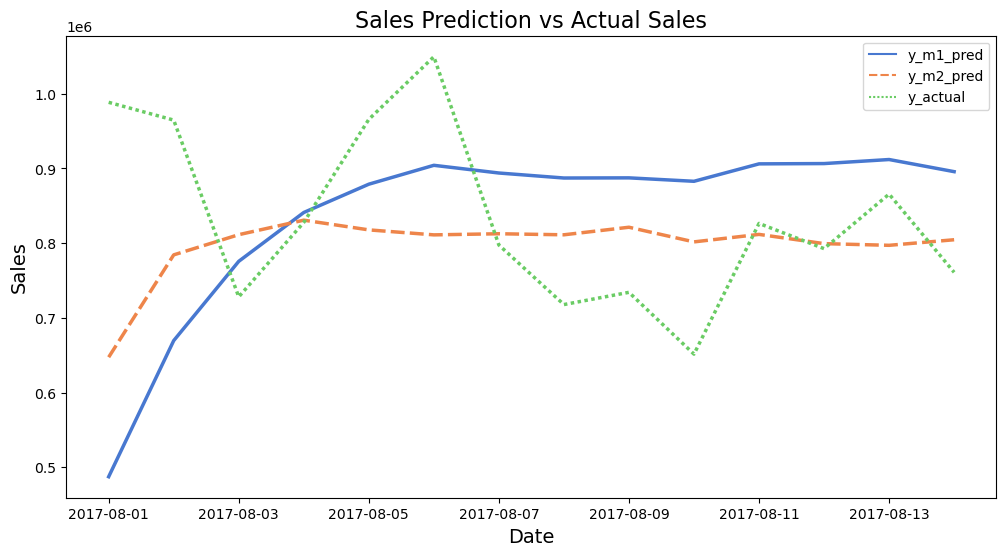

In [39]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=final_df, palette='muted', linewidth=2.5)

plt.title('Sales Prediction vs Actual Sales', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales', fontsize=14)

plt.show()

## 5. Conclusions

After doing some hyperparameters tuning, I am able to improve the model performance by a bit. Sales forecasting is important for most of the business. A model that can accurately forecast future sales can help leadership people to make correct strategy decision to improve business growth. On the other hand, it is also challenge to come up with a model and take all factors into consideration and still achieve a accuarte result. Personally, I find this project useful as it help me to get more familiar with business and real world data, and have some exposure to apply deep learning model on real world problems. In the future, I might try more models, do more feature engineering and make forecast not just on date level, but also on store and family (product type) level to see how it works.